In [68]:
import torch
import pprint
import shap
import ast
import joblib

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear, Sequential, ReLU, MSELoss
from torch.optim import Adam
import torch.nn.functional as F

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski, rdMolDescriptors
from rdkit.Chem import rdchem, MACCSkeys
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Example InChI for Polyacrylic Acid (modify as needed)
inchi = "InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)"
mol = Chem.MolFromInchi(inchi)
mol_with_h = Chem.AddHs(mol)  # Add explicit hydrogens

# Calculate descriptors
tpsa = Descriptors.TPSA(mol_with_h)
num_h_donors = rdMolDescriptors.CalcNumHBD(mol_with_h)
num_h_acceptors = rdMolDescriptors.CalcNumHBA(mol_with_h)
num_rotatable_bonds = Descriptors.NumRotatableBonds(mol_with_h)

# Check if the descriptors are calculated
print(f"TPSA: {tpsa}, NumHDonors: {num_h_donors}, NumHAcceptors: {num_h_acceptors}, NumRotatableBonds: {num_rotatable_bonds}")

TPSA: 37.3, NumHDonors: 1, NumHAcceptors: 2, NumRotatableBonds: 1


In [3]:
# Replace 'your_excel_file.xlsx' with the actual path to your Excel file
excel_file_path = r"C:\Users\LyleL\OneDrive\Desktop\Local Cambridge PhD\Masterlist HSP DATA.xlsx"
sheet_name = 'traindata'

In [4]:
# Read the Excel file into a DataFrame
try:
    traindata_df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    print("Sheet 'traindata' loaded successfully.")
    print(traindata_df.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"File {excel_file_path} not found. Check the file path and name.")
except Exception as e:
    print("An error occurred while loading the Excel sheet:", e)

Sheet 'traindata' loaded successfully.
   No.            Solute                 Solute Repeating Unit InChI  \
0    1  Polyacrylic Acid  InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)   
1    2  Polyacrylic Acid  InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)   
2    3  Polyacrylic Acid  InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)   
3    4  Polyacrylic Acid  InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)   
4    5  Polyacrylic Acid  InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)   

         Solvent                            Solvent InChl  δD_Solvent  \
0          Water                        InChI=1S/H2O/h1H2        15.5   
1        Acetone           InChI=1S/C3H6O/c1-3(2)4/h1-2H3        15.5   
2        Ethanol        InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3        15.8   
3    Isopropanol      InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3        15.8   
4  Ethyl Acetate  InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3        15.8   

    δP_Solvent  δH_Solvent  Solvent Molecular Weight  δD_Polymer   δP_Polymer  \
0       

In [5]:
# Print all column names in the DataFrame
print(traindata_df.columns)

Index(['No.', 'Solute', 'Solute Repeating Unit InChI', 'Solvent',
       'Solvent InChl', 'δD_Solvent', ' δP_Solvent', 'δH_Solvent',
       'Solvent Molecular Weight', 'δD_Polymer', ' δP_Polymer', ' δH_Polymer',
       'HSP Distance', 'Polymer Molecular Weight',
       'Polymer Molar Mass Repeating Unit', 'Solubility', 'Critical Radius'],
      dtype='object')


In [6]:
# All relevant data from the Main Masterlist Excel
relevant_data = traindata_df[['δD_Solvent', ' δP_Solvent', 'δH_Solvent','δD_Polymer', ' δP_Polymer', ' δH_Polymer', 'Polymer Molecular Weight','Polymer Molar Mass Repeating Unit','HSP Distance','Solubility', 'Critical Radius']]
relevant_data

,δD_Solvent,δP_Solvent,δH_Solvent,δD_Polymer,δP_Polymer,δH_Polymer,Polymer Molecular Weight,Polymer Molar Mass Repeating Unit,HSP Distance,Solubility,Critical Radius
0,15.5,16.0,42.3,16.6,8.4,12.2,1800,72.0,31.113797,1,14.8
1,15.5,10.4,7.0,16.6,8.4,12.2,1800,72.0,5.647074,1,14.8
2,15.8,8.8,19.4,16.6,8.4,12.2,1800,72.0,7.300419,1,14.8
3,15.8,6.1,16.4,16.6,8.4,12.2,1800,72.0,4.879492,0,14.8
4,15.8,5.3,7.2,16.6,8.4,12.2,1800,72.0,5.884490,0,14.8
...,...,...,...,...,...,...,...,...,...,...,...
787,15.5,8.6,9.7,16.7,9.8,11.7,2000,44.0,2.638843,1,31.2
788,18.2,6.3,6.1,16.7,9.8,11.7,2000,44.0,6.762611,1,31.2
789,17.0,3.3,11.9,16.7,9.8,11.7,2000,44.0,6.466654,0,31.2
790,18.0,1.4,2.0,16.7,9.8,11.7,2000,44.0,12.884737,1,31.2


In [7]:
# Example InChI strings for solute and solvent
solute_inchis = traindata_df["Solute Repeating Unit InChI"].dropna().tolist()
solvent_inchis = traindata_df["Solvent InChl"].dropna().tolist()

In [8]:
solute_inchis = [str(inchi) for inchi in solute_inchis]
solvent_inchis = [str(inchi) for inchi in solvent_inchis]
len(solute_inchis)

792

In [9]:
# Initialize lists to store the data
solute_data = []
solvent_data = []

In [10]:
# Solute Descriptors
def generate_solute_descriptors(solute_inchis):
    """Generates molecular descriptors for solutes from a list of InChI strings.

    Args:
    solute_inchis (list): A list of InChI strings for the solutes.

    Returns:
    pandas.DataFrame: A DataFrame containing molecular descriptors for each solute.
    """
    solute_data = []

    for solute_inchi in solute_inchis:
        solute_mol = Chem.MolFromInchi(solute_inchi)

        if solute_mol is None:
            print(f"Skipping due to invalid InChI: {solute_inchi}")
            continue

        solute_mol_with_h = Chem.AddHs(solute_mol)
        
        # Generate Morgan fingerprint (radius 2, 2048 bits)
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(solute_mol_with_h, radius=2, nBits=2048)
        # Convert the fingerprint to a list of bits
        morgan_fp_bits = list(morgan_fp.ToBitString())

        solute_descriptors = {
            'SoluteMolecularWeight': Descriptors.MolWt(solute_mol_with_h),
            'LogP': Descriptors.MolLogP(solute_mol_with_h),
            'TPSA': Descriptors.TPSA(solute_mol_with_h),
            'NumHDonors': rdMolDescriptors.CalcNumHBD(solute_mol_with_h),
            'NumHAcceptors': rdMolDescriptors.CalcNumHBA(solute_mol_with_h),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(solute_mol_with_h),
            'MorganFP': morgan_fp_bits
        }
        solute_data.append(solute_descriptors)

    return pd.DataFrame(solute_data)

# Create a DataFrame from the solute data
solute_df = generate_solute_descriptors(solute_inchis)

# Display the DataFrame
solute_df

,SoluteMolecularWeight,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,MorganFP
0,72.063,0.257,37.30,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,72.063,0.257,37.30,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,72.063,0.257,37.30,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,72.063,0.257,37.30,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,72.063,0.257,37.30,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
787,62.068,-1.029,40.46,2,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
788,62.068,-1.029,40.46,2,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
789,62.068,-1.029,40.46,2,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
790,62.068,-1.029,40.46,2,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
# Solvent Descriptors
def generate_solvent_descriptors(solvent_inchis):
    """Generates molecular descriptors for solvents from a list of InChI strings.

    Args:
    solvent_inchis (list): A list of InChI strings for the solvents.

    Returns:
    pandas.DataFrame: A DataFrame containing molecular descriptors for each solvent.
    """
    solvent_data = []

    for solvent_inchi in solvent_inchis:
        solvent_mol = Chem.MolFromInchi(solvent_inchi)

        if solvent_mol is None:
            print(f"Skipping due to invalid InChI: {solvent_inchi}")
            continue

        solvent_mol_with_h = Chem.AddHs(solvent_mol)

        solvent_descriptors = {
            'SolventMolecularWeight': Descriptors.MolWt(solvent_mol_with_h),
            'LogP': Descriptors.MolLogP(solvent_mol_with_h),
            # You can add more solvent-specific descriptors if needed
        }
        solvent_data.append(solvent_descriptors)

    return pd.DataFrame(solvent_data)

# Solvent Descriptors Dataframe
solvent_df = generate_solvent_descriptors(solvent_inchis)
solvent_df

,SolventMolecularWeight,LogP
0,18.015,-0.82470
1,58.080,0.59530
2,46.069,-0.00140
3,60.096,0.38710
4,88.106,0.56940
...,...,...
787,90.078,0.39920
788,169.866,2.84300
789,130.231,2.33920
790,92.141,1.99502


In [12]:
# Dictionary of dielectric constants 
dielectric_constants = {
    'Water': 80.1,
    'Acetone': 20.7,
    'Ethanol': 24.55,
    'Isopropanol': 19.92,
    'Ethyl Acetate': 6.02,
    'Heptane': 1.92,
    'Acetonitrile': 37.5,
    'Tetrahydrofuran': 7.52,
    'Propylene Glycol': 32.0,
    'Benzaldehyde': 17.8,
    'Dimethyl Sulfoxide': 46.68,
    'Acetic Acid': 6.2,
    'Formic Acid': 58.0,
    'Pyridine': 12.4,
    'Dimethylformamide': 36.71,
    '1-Butanol': 17.8,
    '1,4-Dioxane': 2.21,
    'N-Methyl-2-pyrrolidone': 32,
    'Diethylene Glycol Monomethyl Ether': 10.8,
    'Dimethyl Carbonate': 3.1,
    'Dichloromethane': 8.93,
    '1-Octanol': 9.8,
    'Toluene': 2.38,
    'Methanol': 32.70
}
# Create a list of dielectric constants, repeated to match the number of rows in the DataFrame
dielectric_constants_list = list(dielectric_constants.values()) * (792 // len(dielectric_constants))

# Map the dielectric constants to the DataFrame
solvent_df['Dielectric Constant'] = dielectric_constants_list
solvent_df.head()

,SolventMolecularWeight,LogP,Dielectric Constant
0,18.015,-0.8247,80.10
1,58.080,0.5953,20.70
2,46.069,-0.0014,24.55
3,60.096,0.3871,19.92
4,88.106,0.5694,6.02


In [13]:
# Adding the Dipole moments 
dipole_moments = {
    'Water': 1.85,
    'Acetone': 2.69,
    'Ethanol': 1.66,
    'Isopropanol': 1.59,
    'Ethyl Acetate': 1.88,
    'Heptane': 0,
    'Acetonitrile': 3.44,
    'Tetrahydrofuran': 1.75,
    'Propylene Glycol': 2.27,
    'Benzaldehyde': 2.89,
    'Dimethyl Sulfoxide': 4.1,
    'Acetic Acid': 1.74,
    'Formic Acid': 1.42,
    'Pyridine': 2.37,
    'Dimethylformamide': 3.86,
    '1-Butanol': 1.75,
    '1,4-Dioxane': 0.45,
    'N-Methyl-2-pyrrolidone': 4.09,
    'Diethylene Glycol Monomethyl Ether': 1.60,
    'Dimethyl Carbonate': 0.93,
    'Dichloromethane': 1.14,
    '1-Octanol': 1.68,
    'Toluene': 0.31,
    'Methanol': 2.87
}

# Create a list of dipole moments, repeated to match the number of rows in the DataFrame
dipole_moments_list = list(dipole_moments.values()) * (792 // len(dipole_moments))

# Map the dielectric constants to the DataFrame
solvent_df['Dipole Moments'] = dipole_moments_list
solvent_df.head()

,SolventMolecularWeight,LogP,Dielectric Constant,Dipole Moments
0,18.015,-0.8247,80.10,1.85
1,58.080,0.5953,20.70,2.69
2,46.069,-0.0014,24.55,1.66
3,60.096,0.3871,19.92,1.59
4,88.106,0.5694,6.02,1.88


In [14]:
# Adding the Viscosity of Solvents
viscosity = {
    'Water': 1.002,
    'Acetone': 0.316,
    'Ethanol': 1.095,
    'Isopropanol': 2.4,
    'Ethyl Acetate': 0.45,
    'Heptane': 0.41,
    'Acetonitrile': 0.38,
    'Tetrahydrofuran': 0.48,
    'Propylene Glycol': 60.5,
    'Benzaldehyde': 1.7,
    'Dimethyl Sulfoxide': 2.0,
    'Acetic Acid': 1.155,
    'Formic Acid': 1.57,
    'Pyridine': 0.94,
    'Dimethylformamide': 0.92,
    '1-Butanol': 2.94,
    '1,4-Dioxane': 1.54,
    'N-Methyl-2-pyrrolidone': 1.7,
    'Diethylene Glycol Monomethyl Ether': 3.4,
    'Dimethyl Carbonate': 0.59,
    'Dichloromethane': 0.44,
    '1-Octanol': 8.0,
    'Toluene': 0.59,
    'Methanol': 0.56
}

# Create a list of viscosity, repeated to match the number of rows in the DataFrame
viscosity_list = list(viscosity.values()) * (792 // len(viscosity))

# Map the dielectric constants to the DataFrame
solvent_df['Viscosity'] = viscosity_list
solvent_df.head()

,SolventMolecularWeight,LogP,Dielectric Constant,Dipole Moments,Viscosity
0,18.015,-0.8247,80.10,1.85,1.002
1,58.080,0.5953,20.70,2.69,0.316
2,46.069,-0.0014,24.55,1.66,1.095
3,60.096,0.3871,19.92,1.59,2.400
4,88.106,0.5694,6.02,1.88,0.450


In [16]:
# Assuming solute_df and solvent_df are your dataframes for solute and solvent descriptors,
# and additional_data_df is the dataframe with HSP distance, critical radius, and solubility.
combined_df = pd.concat([solute_df, solvent_df, relevant_data], axis=1)
# Print all column names in the DataFrame
print(combined_df.columns)

Index(['SoluteMolecularWeight', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
       'NumRotatableBonds', 'MorganFP', 'SolventMolecularWeight', 'LogP',
       'Dielectric Constant', 'Dipole Moments', 'Viscosity', 'δD_Solvent',
       ' δP_Solvent', 'δH_Solvent', 'δD_Polymer', ' δP_Polymer', ' δH_Polymer',
       'Polymer Molecular Weight', 'Polymer Molar Mass Repeating Unit',
       'HSP Distance', 'Solubility', 'Critical Radius'],
      dtype='object')


In [17]:
combined_df.head()

,SoluteMolecularWeight,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,MorganFP,SolventMolecularWeight,LogP,Dielectric Constant,...,δP_Solvent,δH_Solvent,δD_Polymer,δP_Polymer,δH_Polymer,Polymer Molecular Weight,Polymer Molar Mass Repeating Unit,HSP Distance,Solubility,Critical Radius
0,72.063,0.257,37.3,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18.015,-0.8247,80.10,...,16.0,42.3,16.6,8.4,12.2,1800,72.0,31.113797,1,14.8
1,72.063,0.257,37.3,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",58.080,0.5953,20.70,...,10.4,7.0,16.6,8.4,12.2,1800,72.0,5.647074,1,14.8
2,72.063,0.257,37.3,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",46.069,-0.0014,24.55,...,8.8,19.4,16.6,8.4,12.2,1800,72.0,7.300419,1,14.8
3,72.063,0.257,37.3,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60.096,0.3871,19.92,...,6.1,16.4,16.6,8.4,12.2,1800,72.0,4.879492,0,14.8
4,72.063,0.257,37.3,1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",88.106,0.5694,6.02,...,5.3,7.2,16.6,8.4,12.2,1800,72.0,5.884490,0,14.8


# Call Combined_Dataset Excel File

In [2]:
# Replace 'your_file.csv' with the path to your CSV file
file_path = r"C:\Users\LyleL\OneDrive - University of Cambridge\Desktop\Cambridge PhD\PhD Notes\HSP Project\HSPProp\combined_dataset.csv"
combined_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
combined_df.columns

Index(['SoluteMolecularWeight', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
       'NumRotatableBonds', 'MorganFP', 'SolventMolecularWeight', 'LogP.1',
       'Dielectric Constant', 'Dipole Moments', 'Viscosity', 'δD_Solvent',
       ' δP_Solvent', 'δH_Solvent', 'δD_Polymer', ' δP_Polymer', ' δH_Polymer',
       'Polymer Molecular Weight', 'Polymer Molar Mass Repeating Unit',
       'HSP Distance', 'Solubility', 'Critical Radius'],
      dtype='object')

# Useful Functions

In [6]:
# Function to convert a string representation of a list to an actual list of integers
def convert_string_repr_to_int_list(string_repr):
    string_list = ast.literal_eval(string_repr)
    return [int(bit) for bit in string_list]

def flatten_molecular_fingerprints(df, fingerprint_col):
    """
    Flattens a column of molecular fingerprints in a DataFrame into individual columns.
    Each bit of the fingerprint becomes a separate column.
    Args:
        df (pd.DataFrame): DataFrame with a column of molecular fingerprints.
        fingerprint_col (str): Column name of the molecular fingerprints.
    Returns:
        pd.DataFrame: A modified DataFrame with flattened fingerprint columns.
    """
    # Ensure the fingerprint column exists
    if fingerprint_col not in df.columns:
        raise ValueError(f"'{fingerprint_col}' column not found in the DataFrame.")
    
    # Check if the fingerprints are in the expected format (list of values)
    if not all(isinstance(fp, list) for fp in df[fingerprint_col]):
        raise ValueError(f"Fingerprints in '{fingerprint_col}' are not in the expected format.")

    # Determine the length of the fingerprint (assuming all fingerprints are of the same length)
    fingerprint_length = len(df[fingerprint_col].iloc[0])

    # Create a new DataFrame for the flattened fingerprint
    flattened_df = pd.DataFrame(df[fingerprint_col].tolist(),
                                columns=[f'{fingerprint_col}_{i}' for i in range(fingerprint_length)],
                                index=df.index)

    # Concatenate the new DataFrame with the original DataFrame and drop the original fingerprint column
    df = pd.concat([df.drop(fingerprint_col, axis=1), flattened_df], axis=1)

    return df

# Logistic Regression Model

In [5]:
# Split data into features (X) and target variable (y)
X = combined_df.drop('Solubility', axis=1)  # Replace 'Solubility' with your actual column name
y = combined_df['Solubility']

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Apply the conversion to the DataFrame
X_train['MorganFP'] = X_train['MorganFP'].apply(convert_string_repr_to_int_list)
X_test['MorganFP'] = X_test['MorganFP'].apply(convert_string_repr_to_int_list)

# Now you can use the flatten_molecular_fingerprints function
X_train_flattened = flatten_molecular_fingerprints(X_train, 'MorganFP')
X_test_flattened = flatten_molecular_fingerprints(X_test, 'MorganFP')

In [28]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_flattened, y_train)

LogisticRegression(max_iter=1000)

In [29]:
# Check if X_train and X_test has been flattened properly
X_train_flattened.head()

,SoluteMolecularWeight,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,SolventMolecularWeight,LogP.1,Dielectric Constant,Dipole Moments,...,MorganFP_2038,MorganFP_2039,MorganFP_2040,MorganFP_2041,MorganFP_2042,MorganFP_2043,MorganFP_2044,MorganFP_2045,MorganFP_2046,MorganFP_2047
342,966.845,-1.29420,335.45,0,27,29,41.053,0.52988,37.50,3.44,...,0,0,0,0,0,0,0,0,0,0
244,442.536,6.47332,52.60,0,5,10,88.106,0.56940,6.02,1.88,...,0,0,0,0,0,0,0,0,0,0
314,114.144,1.12560,26.30,0,2,4,46.069,-0.00140,24.55,1.66,...,0,0,0,0,0,0,0,0,0,0
727,90.078,-0.54820,57.53,2,3,3,72.107,0.79680,7.52,1.75,...,0,0,0,0,0,0,0,0,0,0
691,62.499,1.36870,0.00,0,0,0,90.078,0.39920,3.10,0.93,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Predict on the test set
y_pred = model.predict(X_test_flattened)

In [31]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80        95
           1       0.71      0.72      0.71        64

    accuracy                           0.77       159
   macro avg       0.76      0.76      0.76       159
weighted avg       0.77      0.77      0.77       159



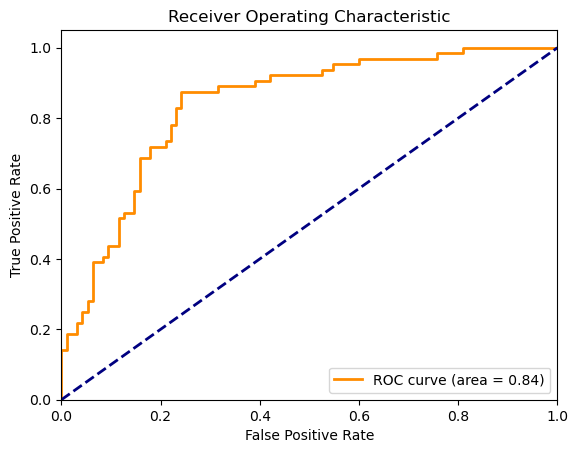

In [32]:
# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test_flattened)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Just a simple logistic regression model - with high quality data

1) Area Under the Curve (AUC): The AUC is 0.84, which is quite good. It means there's an 84% chance that the model will correctly distinguish between a positive and a negative instance. 
In general, an AUC of:
0.90 - 1.00 is considered excellent.
0.80 - 0.90 is considered very good.
0.70 - 0.80 is considered good.
0.60 - 0.70 is considered fair.
0.50 - 0.60 is considered poor.
Below 0.50 is considered fail.

2) Shape of the ROC Curve: The curve is closer to the top left corner, indicating a low false positive rate and a high true positive rate for most threshold values. 
This shape suggests that the model has a good balance between sensitivity and specificity.

3) Comparison with Diagonal Line: The curve is well above the diagonal dashed line (which represents a random classifier). 
This further confirms that the model has a good discriminative ability and performs much better than random guessing.

4) Potential for Improvement: While an AUC of 0.84 is strong, there might still be room for improvement. 
Further analysis of the false positives and false negatives, as well as additional feature engineering, hyperparameter tuning, or trying different models, could potentially increase performance.

In summary, based on the ROC curve and AUC value, your model is performing well at distinguishing between the two classes. 
However, the ultimate assessment of performance should also consider the specific context and cost of misclassification in your application.

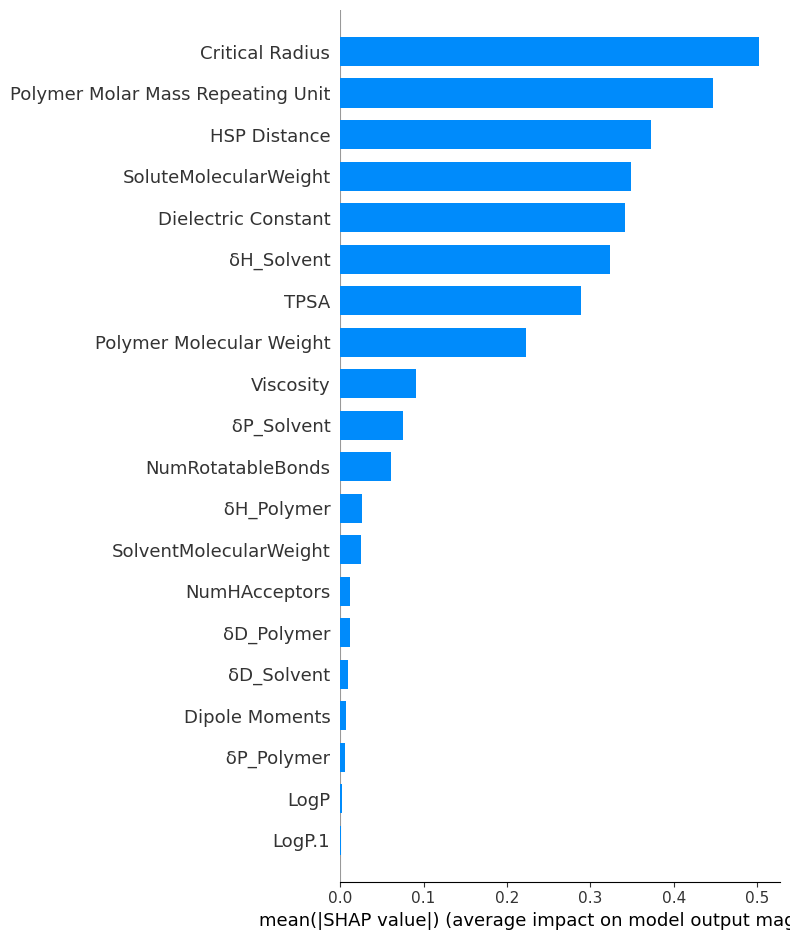

In [57]:
# Assuming 'model' is your trained logistic regression model and 'X_train' is your training dataset

# Create the SHAP Explainer object for a linear model
explainer = shap.LinearExplainer(model, X_train_flattened)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_flattened)

# For visualization: summarize the effects of all the features
shap.summary_plot(shap_values, X_test_flattened, plot_type="bar")

# Plot SHAP values for the first prediction (as an example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_flattened.iloc[0])

# You can modify the index 0 to other values to see SHAP values for different predictions

When choosing a model, consider

Accuracy: 
How important is it to have a highly accurate model? 
Some models may inherently perform better on certain datasets.

Interpretability: 
Do you need to explain the model's decisions? 
Models like decision trees are easier to explain than, say, neural networks.

Training Time: 
How much computational resource and time do you have? 
Some models require more resources to train, like neural networks, especially with large datasets.

Data Size and Complexity: 
How large and complex is your dataset? 
Models like SVM might not scale well to very large datasets without kernel approximations.

Nonlinearity: 
If your data is highly non-linear, models like GBM or neural networks might be more appropriate.

# Saving the Data into a CSV

In [43]:
# saving the data into csv

# Assuming 'dataframe' is your DataFrame object
dataframe = combined_df  # Replace with your actual DataFrame variable

# Define the filename for the CSV file
csv_filename = "combined_dataset.csv"

# Save the DataFrame to a CSV file
dataframe.to_csv(csv_filename, index=False)  # Set index=False if you don't want to save the index

# Random Forest

In [12]:
# Assuming your combined dataset is in a DataFrame called 'combined_df'
# and that 'Solubility' is the target variable column name

# Split the data into features and target variable
X = combined_df.drop('Solubility', axis=1)
y = combined_df['Solubility']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the conversion to the DataFrame
X_train['MorganFP'] = X_train['MorganFP'].apply(convert_string_repr_to_int_list)
X_test['MorganFP'] = X_test['MorganFP'].apply(convert_string_repr_to_int_list)
# Assuming X_train is your DataFrame and 'MorganFP' is the column with fingerprints
X_train_flattened = flatten_molecular_fingerprints(X_train, 'MorganFP')
# Assuming you have a function flatten_molecular_fingerprints from earlier
X_test_flattened = flatten_molecular_fingerprints(X_test, 'MorganFP')

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100,  # Number of trees in the forest
                                       random_state=42,  # Seed for reproducibility
                                       n_jobs=-1,        # Use all cores of processor
                                       class_weight='balanced')  # Handle class imbalance

In [14]:
# Train the model on the training data
rf_classifier.fit(X_train_flattened, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [15]:
# Predict on the test data
y_pred = rf_classifier.predict(X_test_flattened)

In [16]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        95
         1.0       0.89      0.78      0.83        64

    accuracy                           0.87       159
   macro avg       0.88      0.86      0.87       159
weighted avg       0.88      0.87      0.87       159

Accuracy Score: 0.8742138364779874


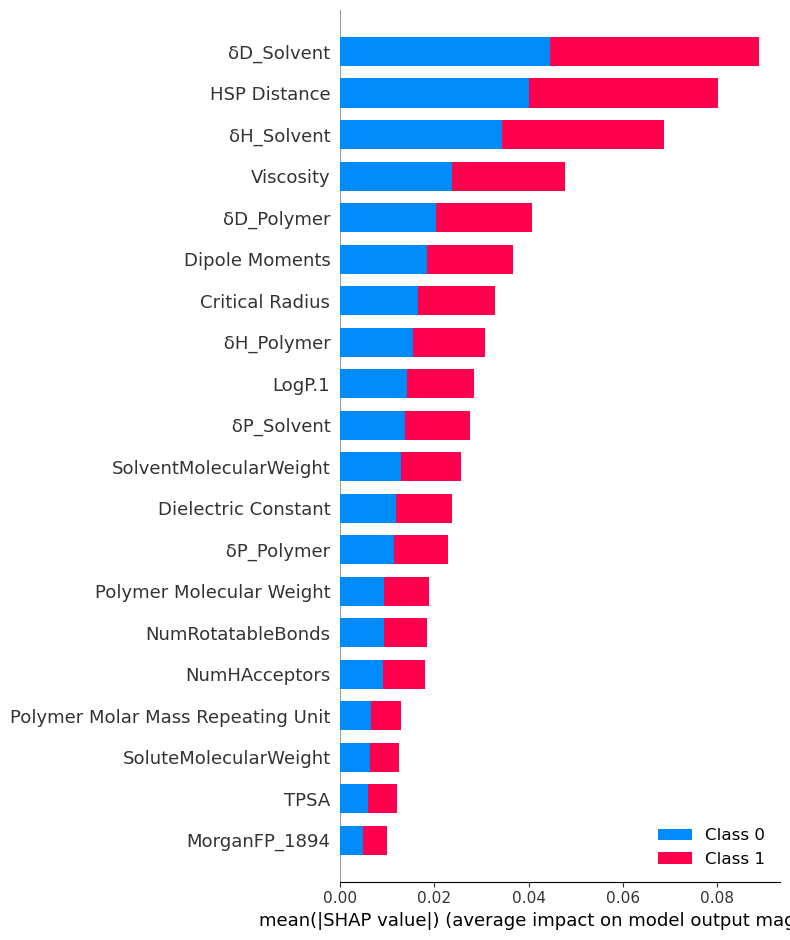

In [10]:
# Create the SHAP Explainer object using your random forest model
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_flattened)

# Plot the summary bar plot for the SHAP values
shap.summary_plot(shap_values, X_test_flattened, plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()
# Plot SHAP values for a single instance
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_flattened.iloc[0])

In [55]:
# Feature Importances (optional)
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(importances, feature_names), reverse=True)
print("Feature importances:\n", feature_importances)

Feature importances:
 [(0.08888015399306395, 'Polymer Molar Mass Repeating Unit'), (0.0881404282597252, 'Viscosity'), (0.08548428566670761, ' δP_Solvent'), (0.07557264093208622, 'Dipole Moments'), (0.07005943386659759, 'SolventMolecularWeight'), (0.06938516172767885, 'δD_Solvent'), (0.06805948704863504, 'LogP'), (0.06797854861989924, 'Dielectric Constant'), (0.059133070947467885, 'MorganFP'), (0.02063394336853365, 'δH_Solvent'), (0.018882808807410497, 'HSP Distance'), (0.018517181423654702, ' δP_Polymer'), (0.015016486516210565, 'δD_Polymer'), (0.014505440805686718, ' δH_Polymer'), (0.008862850232962889, 'SoluteMolecularWeight'), (0.008117975702315327, 'Polymer Molecular Weight'), (0.00730874910656685, 'NumRotatableBonds'), (0.005671215508968696, 'NumHAcceptors'), (0.00524828860013968, 'LogP'), (0.00409633765494363, 'TPSA'), (0.0020189562470374653, 'NumHDonors'), (0.0, 'Critical Radius')]


## Random Forest Analysis

Precision: Indicates how many of the items identified as positive by the model are actually positive. Higher precision means fewer false positives.

Class 0 (assumed to be "not soluble"): 87% precision means that when the model predicts a solute is not soluble, it is correct 87% of the time.
Class 1 (assumed to be "soluble"): 85% precision means that when the model predicts a solute is soluble, it is correct 85% of the time.

Recall: Shows how many of the actual positive items were identified correctly. Higher recall means fewer false negatives.

Class 0: 91% recall indicates the model correctly identifies 91% of all actual non-soluble instances.
Class 1: 80% recall indicates the model correctly identifies 80% of all actual soluble instances.

F1-Score: The harmonic mean of precision and recall. An F1-score is a balanced measure when you want to seek a balance between precision and recall.

Class 0: An F1-score of 89% is quite high, suggesting a good balance for non-soluble predictions.
Class 1: An F1-score of 82% is also good, though there's slightly more room for improvement compared to class 0.
Accuracy: The proportion of total predictions that were correct. An accuracy of 86.16% means that the model makes the right prediction about whether a solute is soluble or not in approximately 86 out of 100 cases.

Macro Avg: The average of precision, recall, and F1-score across all classes, treating all classes equally regardless of their support (number of instances).

Macro avg of 85% suggests overall good performance across both classes.
Weighted Avg: Similar to macro average, but takes the support of each class into account. It's more representative of the model's performance when there is class imbalance.

A weighted average of 86% suggests that when class support is considered, the model still shows good performance.
In addition to these metrics, you can perform further evaluations using:

Confusion Matrix: To visualize true positives, false positives, true negatives, and false negatives.
ROC Curve and AUC: To assess the model's ability to distinguish between classes across all thresholds.
Considering the provided metrics, your Random Forest model is performing well. Both classes have high precision and recall, resulting in good F1-scores. The accuracy is also high, indicating robust overall performance. You may want to investigate specific instances where the model is making errors to see if there's a pattern or a particular aspect of the data that the model is struggling with, which could guide further model improvement or data preprocessing.

Considering the provided metrics, your Random Forest model is performing well. Both classes have high precision and recall, resulting in good F1-scores. The accuracy is also high, indicating robust overall performance. You may want to investigate specific instances where the model is making errors to see if there's a pattern or a particular aspect of the data that the model is struggling with, which could guide further model improvement or data preprocessing.

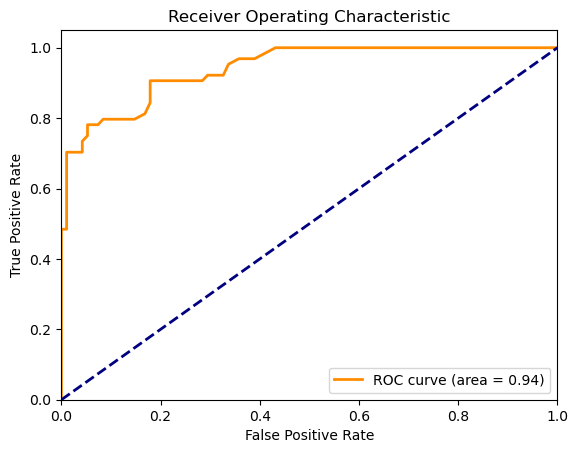

In [17]:
# Predict probabilities for the test set
y_scores = rf_classifier.predict_proba(X_test_flattened)[:, 1]  # get the probability of class 1

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Save the model to a file
model_filename = 'rf_classifier.joblib'
joblib.dump(rf_classifier, model_filename)

print(f"Model saved to {model_filename}")

Model saved to rf_classifier.joblib


In [68]:
# Hyperparameter Tuning with Grid Search

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_
print('Best parameters for Random Forest:', best_parameters)

In [ ]:
# Feature Engineering: Adding Interaction Terms
# Use PolynomialFeatures for interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Now split the enhanced data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit the Random Forest to the new data
rf.fit(X_train_poly, y_train)

# Neural Network (Multilayer Preceptron)

For a binary classification task like predicting solubility, a feedforward neural network, also known as a Multilayer Perceptron (MLP), is often a good starting point. MLPs can model complex relationships between inputs and outputs and are capable of learning non-linear decision boundaries.

In [60]:
# Assuming you have a DataFrame `combined_df` and 'Solubility' is the target variable
X = combined_df.drop('Solubility', axis=1)
y = combined_df['Solubility']

In [88]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the conversion to the DataFrame
X_train['MorganFP'] = X_train['MorganFP'].apply(convert_string_repr_to_int_list)
X_test['MorganFP'] = X_test['MorganFP'].apply(convert_string_repr_to_int_list)
# Example usage
# Assuming X_train is your DataFrame and 'MorganFP' is the column with fingerprints
X_train_flattened = flatten_molecular_fingerprints(X_train, 'MorganFP')
# Assuming you have a function flatten_molecular_fingerprints from earlier
X_test_flattened = flatten_molecular_fingerprints(X_test, 'MorganFP')

# It's a good practice to scale your data for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

array([[ 3.79242168, -1.16565776,  4.07083692, ...,  0.        ,
         0.        , -0.17107978],
       [ 1.27603299,  3.06973237,  0.0704878 , ...,  0.        ,
         0.        , -0.17107978],
       [-0.30006415,  0.15378487, -0.30147324, ...,  0.        ,
         0.        , -0.17107978],
       ...,
       [-0.64592607,  0.19015434, -0.67343429, ...,  0.        ,
         0.        , -0.17107978],
       [ 1.97713494,  2.47199727,  1.53075312, ...,  0.        ,
         0.        , -0.17107978],
       [-0.59321384, -0.08047372, -0.33697219, ...,  0.        ,
         0.        , -0.17107978]])

In [66]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Hidden layer
model.add(Dense(32, activation='relu'))  # Additional hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

In [67]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To log when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [68]:
# Train the model with early stopping and a validation split
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=8,  # Set batch size to 8
    validation_split=0.2,  # Use 20% of the training data for validation
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

Epoch 1/100
64/64 [==============================] - 1s 4ms/step - loss: 0.6594 - accuracy: 0.6364 - val_loss: 0.5824 - val_accuracy: 0.7008
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5689 - accuracy: 0.7055 - val_loss: 0.5494 - val_accuracy: 0.7717
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.7431 - val_loss: 0.5437 - val_accuracy: 0.7323
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4960 - accuracy: 0.7609 - val_loss: 0.5419 - val_accuracy: 0.7402
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.7787 - val_loss: 0.4955 - val_accuracy: 0.8110
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.7866 - val_loss: 0.5082 - val_accuracy: 0.7874
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4233 - accuracy: 0.8043 - val_loss: 0.5180 - val_accuracy: 0.7402
Epoch 8/100
6

In [69]:
# Evaluate the model
scores = model.evaluate(X_test_scaled, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

5/5 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.8553

Accuracy: 85.53%


5/5 [==============================] - 0s 1ms/step


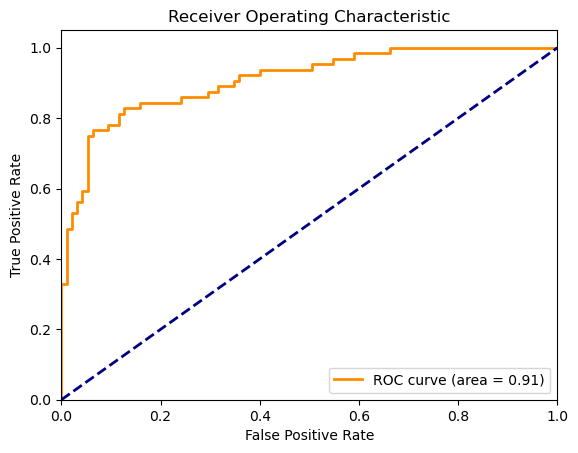

In [70]:
# Predict probabilities for the test set
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [71]:
# Predict class labels for the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype('int32')

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

5/5 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88        95
     Class 1       0.83      0.81      0.82        64

    accuracy                           0.86       159
   macro avg       0.85      0.85      0.85       159
weighted avg       0.86      0.86      0.86       159



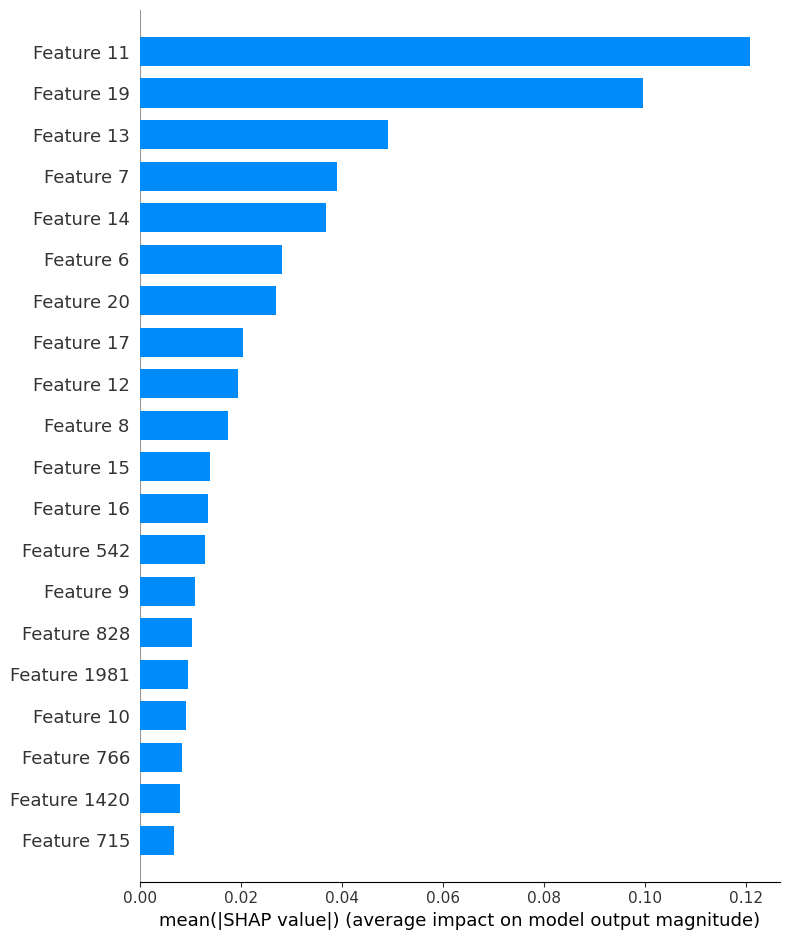

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [103]:
# Create the SHAP Explainer object using your random forest model
explainer = shap.DeepExplainer(model, shap.sample(X_train_scaled, 100))

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100))

# Plot the summary bar plot for the SHAP values
shap.summary_plot(shap_values[0], shap.sample(X_test_scaled, 100), plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()
# Plot SHAP values for a single instance (for example, the first instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], shap.sample(X_test_scaled, 100).iloc[0])

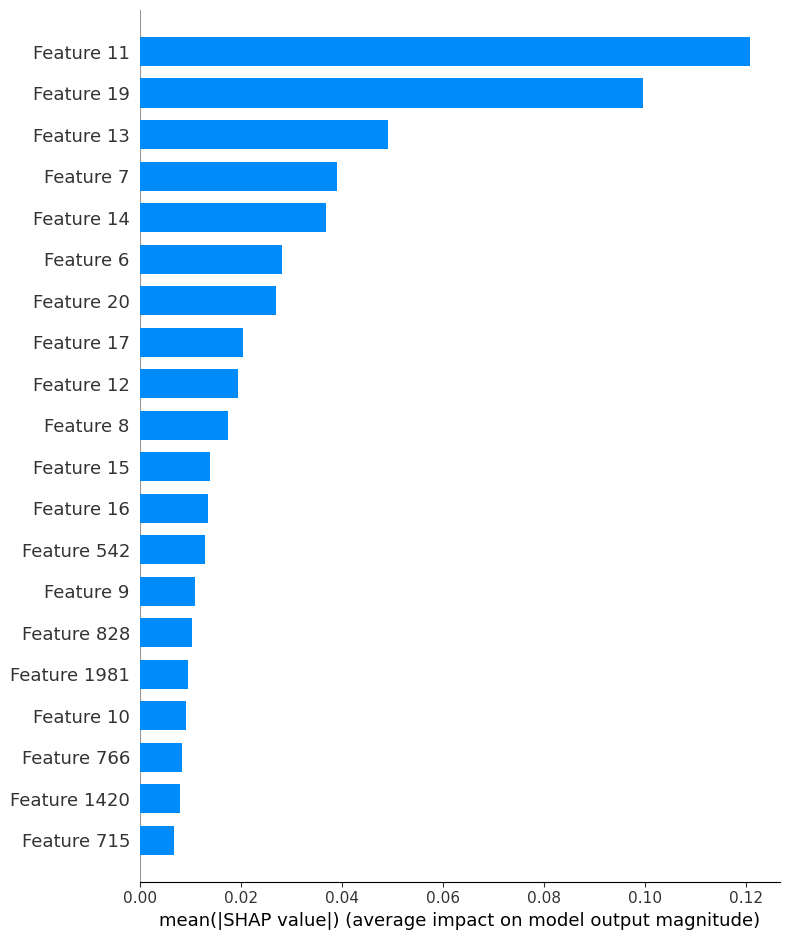

TypeError: Object of type EagerTensor is not JSON serializable

In [104]:
# Create the SHAP Explainer object using your random forest model
explainer = shap.DeepExplainer(model, shap.sample(X_train_scaled, 100))

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100))

# Plot the summary bar plot for the SHAP values
shap.summary_plot(shap_values[0], shap.sample(X_test_scaled, 100), plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()
# Plot SHAP values for a single instance (for example, the first instance)
# Accessing the first instance using standard NumPy indexing
first_instance = shap.sample(X_test_scaled, 100)[0]
shap.force_plot(explainer.expected_value[0], shap_values[0][0], first_instance)

In [106]:
# Convert the scaled data back to a DataFrame with named columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_flattened.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_flattened.columns)

In [108]:
# Create the SHAP Explainer object using your model
explainer = shap.DeepExplainer(model, shap.sample(X_train_scaled_df, 100))

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(shap.sample(X_test_scaled_df, 100))

# Plot the summary bar plot for the SHAP values using named features
shap.summary_plot(shap_values[0], shap.sample(X_test_scaled_df, 100), plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()

# Plot SHAP values for a single instance using named features
shap.force_plot(explainer.expected_value[0], shap_values[0][0], shap.sample(X_test_scaled_df, 100).iloc[0])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AttributeError: Exception encountered when calling layer 'sequential_1' (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'sequential_1' (type Sequential):
  • inputs=['     SoluteMolecularWeight      LogP      TPSA  NumHDonors  NumHAcceptors  \\\n213              -0.415567 -0.758887  0.140213    1.454636      -0.066086   \n503              -0.547931  0.286340 -0.673434   -0.654836      -0.616513   \n473               3.792422 -1.165658  4.070837   -0.654836       4.337327   \n157               3.792422 -1.165658  4.070837   -0.654836       4.337327   \n627              -0.271234  0.649762 -0.387321    0.399900      -0.433037   \n..                     ...       ...       ...         ...            ...   \n403              -0.098521 -0.240608  0.070488   -0.654836       0.117390   \n205              -0.381573  0.208366 -0.627611   -0.654836      -0.433037   \n64                1.276033  3.069732  0.070488   -0.654836       0.300865   \n480              -0.348020  0.810289 -0.673434   -0.654836      -0.616513   \n316               1.276033  3.069732  0.070488   -0.654836       0.300865   \n\n     NumRotatableBonds  SolventMolecularWeight    LogP.1  Dielectric Constant  \\\n213          -0.182156                2.715495  2.159743            -0.664186   \n503          -0.629652               -1.886434 -1.413518             3.156885   \n473           3.696144               -0.612480 -0.521494            -0.810758   \n157           3.696144               -0.186050  0.148693            -0.187962   \n627          -0.331322                0.237713 -0.055315            -0.820422   \n..                 ...                     ...       ...                  ...   \n403          -0.331322               -1.461338 -0.991473             0.612009   \n205          -0.480487               -0.672242 -0.030082            -0.032263   \n64            0.862002                0.297475 -0.221132            -0.977195   \n480          -0.480487                0.359996  1.333597            -1.015852   \n316           0.862002               -0.186050  0.148693            -0.187962   \n\n     Dipole Moments  ...  MorganFP_2038  MorganFP_2039  MorganFP_2040  \\\n213       -0.772398  ...            0.0            0.0            0.0   \n503       -0.118456  ...            0.0            0.0            0.0   \n473       -0.219771  ...            0.0            0.0            0.0   \n157       -0.210560  ...            0.0            0.0            0.0   \n627       -0.090824  ...            0.0            0.0            0.0   \n..              ...  ...            ...            ...            ...   \n403        0.821012  ...            0.0            0.0            0.0   \n205        0.655223  ...            0.0            0.0            0.0   \n64        -0.965818  ...            0.0            0.0            0.0   \n480       -1.536867  ...            0.0            0.0            0.0   \n316       -0.210560  ...            0.0            0.0            0.0   \n\n     MorganFP_2041  MorganFP_2042  MorganFP_2043  MorganFP_2044  \\\n213            0.0            0.0            0.0      -0.189754   \n503            0.0            0.0            0.0      -0.189754   \n473            0.0            0.0            0.0      -0.189754   \n157            0.0            0.0            0.0      -0.189754   \n627            0.0            0.0            0.0      -0.189754   \n..             ...            ...            ...            ...   \n403            0.0            0.0            0.0      -0.189754   \n205            0.0            0.0            0.0      -0.189754   \n64             0.0            0.0            0.0      -0.189754   \n480            0.0            0.0            0.0      -0.189754   \n316            0.0            0.0            0.0      -0.189754   \n\n     MorganFP_2045  MorganFP_2046  MorganFP_2047  \n213            0.0            0.0       -0.17108  \n503            0.0            0.0       -0.17108  \n473            0.0            0.0       -0.17108  \n157            0.0            0.0       -0.17108  \n627            0.0            0.0       -0.17108  \n..             ...            ...            ...  \n403            0.0            0.0       -0.17108  \n205            0.0            0.0       -0.17108  \n64             0.0            0.0       -0.17108  \n480            0.0            0.0       -0.17108  \n316            0.0            0.0       -0.17108  \n\n[100 rows x 2069 columns]']
  • training=False
  • mask=None

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

4094/4094 [==============================] - 4s 909us/step


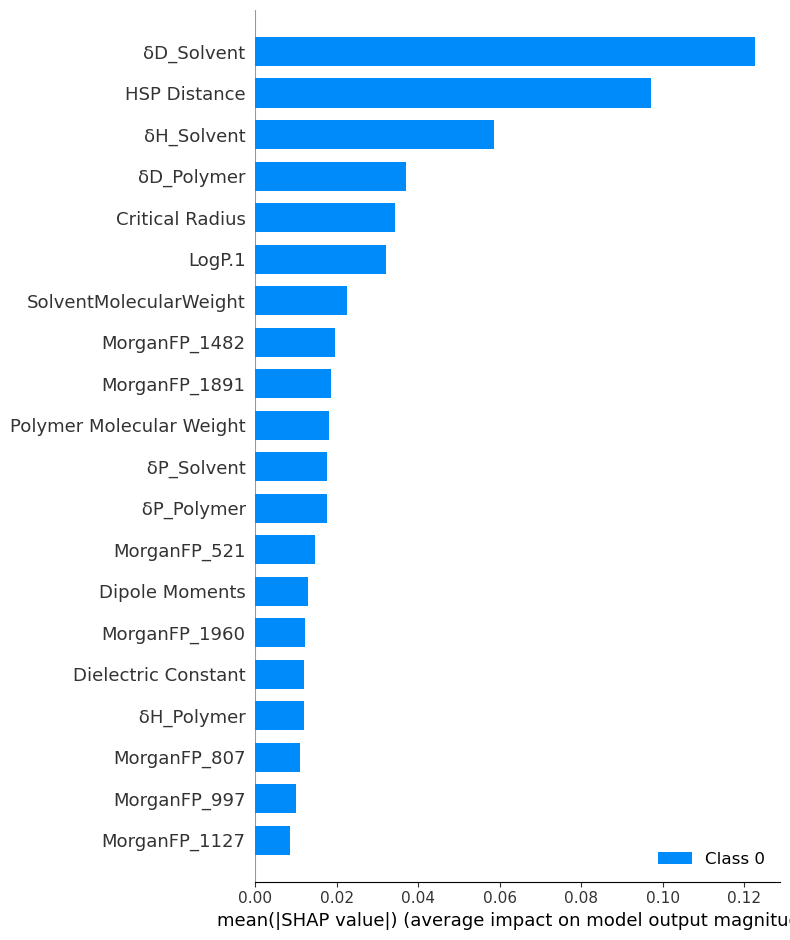

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [116]:
# Create a background dataset (a small random sample of the training data)
background_data = shap.sample(X_train_scaled_df, 50)

# Initialize the SHAP KernelExplainer using your model and the background dataset
explainer = shap.KernelExplainer(model.predict, background_data)

# Calculate SHAP values for a sample of the test set
shap_values = explainer.shap_values(shap.sample(X_test_scaled_df, 20))

# Plot the summary bar plot for the SHAP values using named features
shap.summary_plot(shap_values, shap.sample(X_test_scaled_df, 20), plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()

# Plot SHAP values for a single instance using named features
shap.force_plot(explainer.expected_value, shap_values[0], shap.sample(X_test_scaled_df, 20).iloc[0])

# Simplified HSPProp

In [34]:
# Define the features for the simplified model
features = ['SoluteMolecularWeight', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
            'SolventMolecularWeight', 'δD_Solvent',
       ' δP_Solvent', 'δH_Solvent', 'LogP.1', 'Dielectric Constant', 'Dipole Moments', 'Viscosity']

# Extract features (X) and target variable (y)
X = combined_df[features]
y = combined_df['Solubility']

# Display the first few rows of X and y for verification
# print(X.head())
# print(y.head())

# S-HSPProp Logistic Regression

In [35]:
# Logistic Regression (Simplified HSPProp)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [50]:
# Predict on the test set
y_pred = model.predict(X_test)

In [51]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72        95
         1.0       0.59      0.53      0.56        64

    accuracy                           0.66       159
   macro avg       0.64      0.64      0.64       159
weighted avg       0.66      0.66      0.66       159



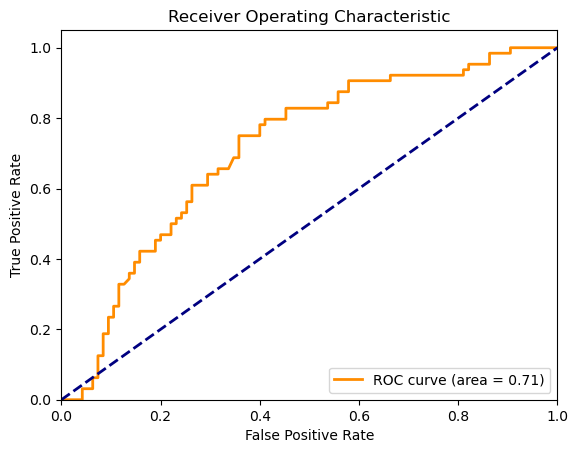

In [52]:
# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

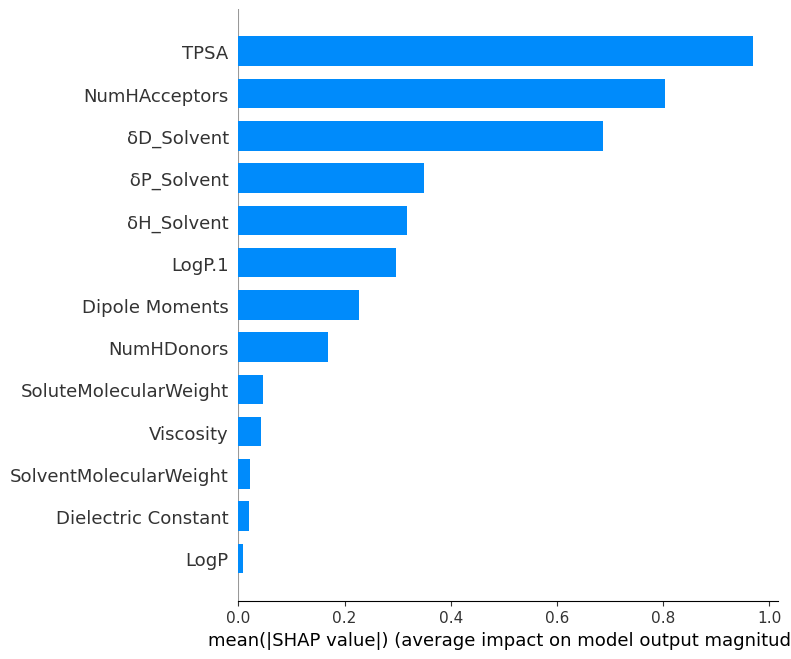

In [53]:
# Assuming 'model' is your trained logistic regression model and 'X_train' is your training dataset

# Create the SHAP Explainer object for a linear model
explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# For visualization: summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values for the first prediction (as an example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# You can modify the index 0 to other values to see SHAP values for different predictions

# S-HSPProp Random Forest

In [54]:
# Random Forest (Simplified HSPProp)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100,  # Number of trees in the forest
                                       random_state=42,  # Seed for reproducibility
                                       n_jobs=-1,        # Use all cores of processor
                                       class_weight='balanced')  # Handle class imbalance

In [56]:
# Train the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [57]:
# Predict on the test data
y_pred = rf_classifier.predict(X_test)

In [58]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87        95
         1.0       0.77      0.89      0.83        64

    accuracy                           0.85       159
   macro avg       0.84      0.86      0.85       159
weighted avg       0.86      0.85      0.85       159

Accuracy Score: 0.8490566037735849


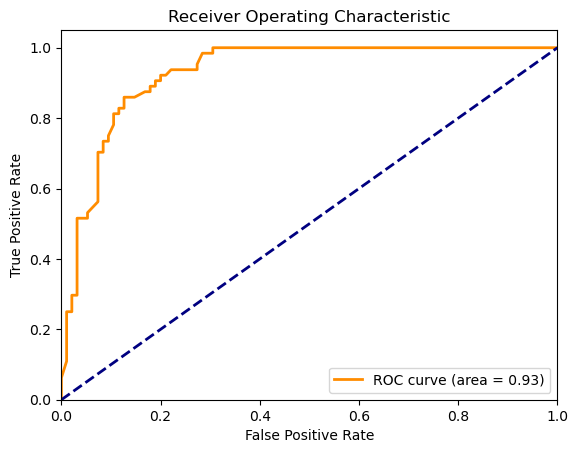

In [61]:
# Predict probabilities for the test set
y_scores = rf_classifier.predict_proba(X_test)[:, 1]  # get the probability of class 1

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

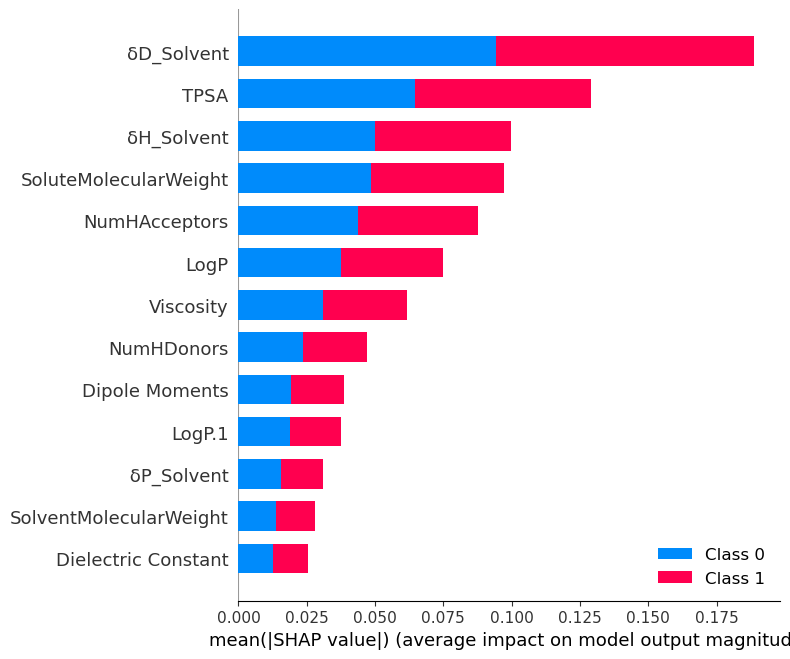

In [60]:
# Create the SHAP Explainer object using your random forest model
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the summary bar plot for the SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Initialize JavaScript visualization in the Jupyter notebook
shap.initjs()
# Plot SHAP values for a single instance
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

# S-HSPProp (Multi-Layer Perception - Neural Network)

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# It's a good practice to scale your data for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
# Define a simple multi-layer perception model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Hidden layer
model.add(Dense(32, activation='relu'))  # Additional hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

In [77]:
# Define a complex multi-layer perception model

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden layer 1
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden layer 2
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden layer 3
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [78]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To log when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [79]:
# Train the model with early stopping and a validation split
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=8,  # Set batch size to 8
    validation_split=0.2,  # Use 20% of the training data for validation
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

Epoch 1/100
64/64 [==============================] - 2s 6ms/step - loss: 2.5412 - accuracy: 0.6166 - val_loss: 2.2221 - val_accuracy: 0.5906
Epoch 2/100
64/64 [==============================] - 0s 3ms/step - loss: 2.1500 - accuracy: 0.6265 - val_loss: 2.0237 - val_accuracy: 0.5906
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 1.9452 - accuracy: 0.6423 - val_loss: 1.8999 - val_accuracy: 0.5906
Epoch 4/100
64/64 [==============================] - 0s 3ms/step - loss: 1.7907 - accuracy: 0.6759 - val_loss: 1.8130 - val_accuracy: 0.5906
Epoch 5/100
64/64 [==============================] - 0s 3ms/step - loss: 1.7416 - accuracy: 0.6561 - val_loss: 1.7165 - val_accuracy: 0.5906
Epoch 6/100
64/64 [==============================] - 0s 3ms/step - loss: 1.6379 - accuracy: 0.6640 - val_loss: 1.6641 - val_accuracy: 0.5039
Epoch 7/100
64/64 [==============================] - 0s 3ms/step - loss: 1.5990 - accuracy: 0.6324 - val_loss: 1.5676 - val_accuracy: 0.5906
Epoch 8/100
6

Epoch 59/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.8063 - val_loss: 0.6805 - val_accuracy: 0.6772
Epoch 60/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4690 - accuracy: 0.8123 - val_loss: 0.6935 - val_accuracy: 0.6850
Epoch 61/100
64/64 [==============================] - 0s 3ms/step - loss: 0.5029 - accuracy: 0.7767 - val_loss: 0.7108 - val_accuracy: 0.6850
Epoch 62/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4554 - accuracy: 0.8182 - val_loss: 0.8225 - val_accuracy: 0.6929
Epoch 63/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.8024 - val_loss: 0.7396 - val_accuracy: 0.7480
Epoch 64/100
64/64 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.8024 - val_loss: 0.6509 - val_accuracy: 0.7402
Epoch 65/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4786 - accuracy: 0.8142 - val_loss: 0.6644 - val_accuracy: 0.7008
Epoch 

In [80]:
# Evaluate the model
scores = model.evaluate(X_test_scaled, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

5/5 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.8113

Accuracy: 81.13%


5/5 [==============================] - 0s 5ms/step


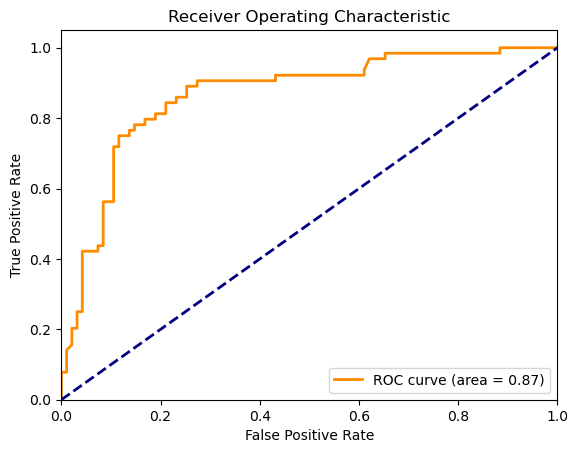

In [81]:
# Predict probabilities for the test set
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()